In [1]:
import tensorflow as tf
import keras
import keras.layers as lay
import numpy as np
import matplotlib.pyplot as plt
import src.generator as gen_fun

In [2]:
generator = gen_fun.Generator(input_shape=(128,),final_resolution=32)
signal = tf.random.normal((1,128),0,1)

(1, 32, 32, 3)


/Users/villeneveoliveira/code/venv311/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


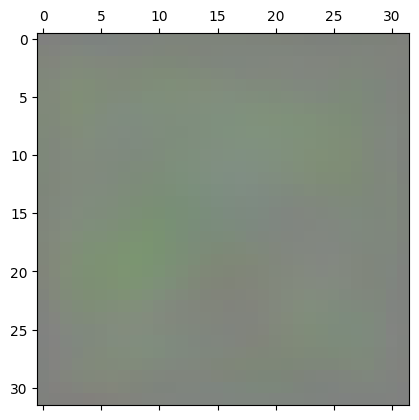

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ upsampling_0 (UpSampling2D)     │ (1, 8, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsampling_1 (UpSampling2D)     │ (1, 16, 16, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsampling_2 (UpSampling2D)     │ (1, 32, 32, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (1, 4, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (1, 8, 8, 128)         │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (1, 8, 8, 128)         │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (1, 16, 16, 64)        │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (1, 16, 16, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (1, 32, 32, 32)        │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (1, 32, 32, 32)        │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ brain (Dense)                   │ (1, 4096)              │       528,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ toRGB_0 (Conv2D)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ toRGB_1 (Conv2D)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ toRGB_2 (Conv2D)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ toRGB_3 (Conv2D)                │ (1, 32, 32, 3)         │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,109,539 (4.23 MB)

 Trainable params: 1,109,539 (4.23 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
out = generator(signal,resolution=32,fade=0)
print(out.shape)
plt.matshow(np.uint8(out[0]*127.5+127.5))
plt.show()
generator.summary()